Datos de jugadores:
   person_id first_name     last_name  season_exp position     team_id
0      76001       Alaa     Abdelnaby         5.0  Forward  1610612757
1      76002       Zaid    Abdul-Aziz        10.0   Center  1610612745
2      76003     Kareem  Abdul-Jabbar        20.0   Center  1610612747
3        949    Shareef   Abdur-Rahim        13.0  Forward  1610612763
4      76006     Forest          Able         1.0    Guard  1610612755

Datos salariales:
   player_id          full_name    Salary  Age   PTS     Team
0     201939      Stephen Curry  48070014   34  29.4      GSW
1     202322          John Wall  47345760   32  11.4      LAC
2     201566  Russell Westbrook  47080179   34  15.9  LAL/LAC
3       2544       LeBron James  44474988   38  28.9      LAL
4     201142       Kevin Durant  44119845   34  29.1  BRK/PHO

Datos historicos (game):
    game_id season_id  team_id_home team_abbreviation_home  pts_home  \
0  20900476     22009    1610612747                    LAL     10

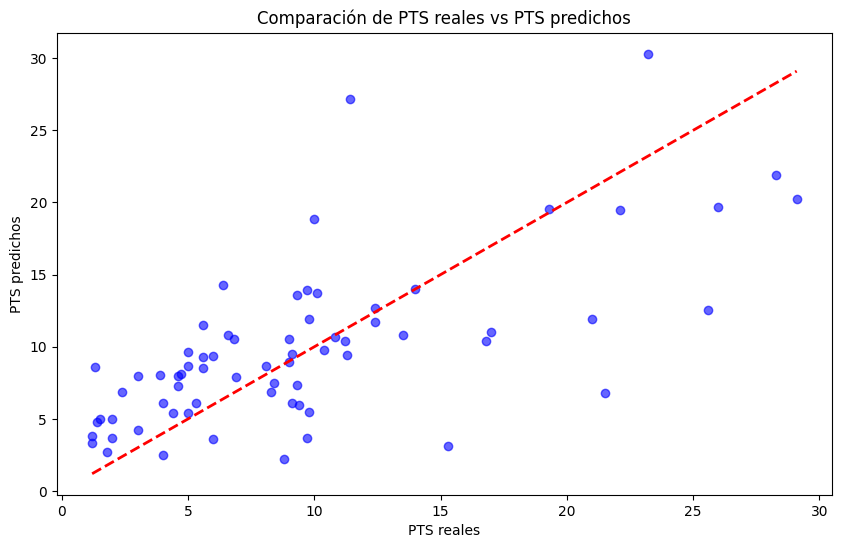

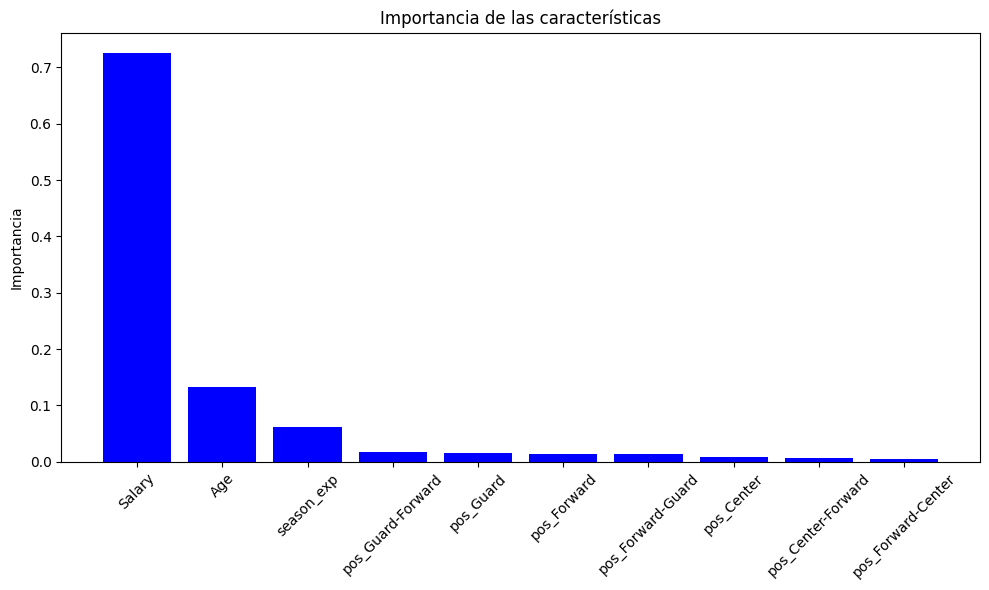


Ejemplo de predicciones (PTS) en el conjunto de prueba:
     PTS_real  PTS_predicho
194       5.6      8.518000
157       1.2      3.831000
225       2.4      6.849000
208      10.1     13.697000
318      12.4     12.652000
329       9.0      8.910000
319       1.2      3.312758
260       4.0      2.463600
114       8.8      2.208000
220       1.3      8.571000


In [ ]:
#!/usr/bin/env python
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

def main():
    # Conectarse a la base de datos y leer las tablas historicas y de rendimiento
    db_path = # Ingresa el path de BD
    conn = sqlite3.connect(db_path)
    
    # Extraer datos históricos de partidos (la tabla "game" contiene estadísticas del encuentro)
    query_game = """
    SELECT game_id, season_id, team_id_home, team_abbreviation_home, pts_home, plus_minus_home,
           team_id_away, team_abbreviation_away, pts_away, plus_minus_away, game_date
    FROM game
    WHERE game_date >= '2010-01-01'
    """
    game_df = pd.read_sql_query(query_game, conn)
    
    # Extraer información individual básica (por ejemplo, atributos físicos y experiencia) de common_player_info
    query_player = """
    SELECT person_id, first_name, last_name, season_exp, position, team_id 
    FROM common_player_info
    """
    player_df = pd.read_sql_query(query_player, conn)
    
    # Extraer datos salariales y de rendimiento individual (se usa PTS como proxy de rendimiento) de nba_salaries
    query_salary = """
    SELECT player_id, full_name, Salary, Age, PTS, Team
    FROM nba_salaries
    """
    salary_df = pd.read_sql_query(query_salary, conn)
    
    conn.close()
    
    # Imprimir una vista previa de los datos
    print("Datos de jugadores:")
    print(player_df.head())
    print("\nDatos salariales:")
    print(salary_df.head())
    print("\nDatos historicos (game):")
    print(game_df.head())
    
    # Para el modelo predictivo de rendimiento y contribución, definimos la variable objetivo.
    # En este ejemplo, usaremos 'PTS' (promedio de puntos) como proxy de rendimiento individual.
    
    # Unir la información individual (player_df) con los datos salariales (salary_df)
    player_df['person_id'] = pd.to_numeric(player_df['person_id'], errors='coerce')
    salary_df['player_id'] = pd.to_numeric(salary_df['player_id'], errors='coerce')
    data = pd.merge(player_df, salary_df, left_on='person_id', right_on='player_id', how='inner')
    
    # Eliminar registros con datos faltantes claves en Salary o PTS
    data = data.dropna(subset=['Salary', 'PTS'])
    
    # Convertir a tipo numérico las columnas importantes y limpiar la columna de posición
    data['Salary'] = pd.to_numeric(data['Salary'], errors='coerce')
    data['PTS'] = pd.to_numeric(data['PTS'], errors='coerce')
    data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
    data['season_exp'] = pd.to_numeric(data['season_exp'], errors='coerce')
    data['position_clean'] = data['position'].astype(str).str.strip()
    
    # Para diseñar el modelo predictivo, usaremos las siguientes variables como predictores:
    # - Age (edad)
    # - season_exp (experiencia)
    # - Salary (salario)
    # - Variables dummy de la posición (para capturar el rol del jugador)
    features = data[['Age', 'season_exp', 'Salary']].copy()
    positions_dummies = pd.get_dummies(data['position_clean'], prefix='pos')
    features = pd.concat([features, positions_dummies], axis=1)
    
    # La variable objetivo será el rendimiento, en este ejemplo "PTS" (puntos por juego)
    target = data['PTS']
    
    # Separar los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    # Entrenar un modelo de regresión supervisado. Aquí se utiliza RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predecir sobre el conjunto de prueba y evaluar el desempeño del modelo
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print("\nDesempeño del modelo predictivo de rendimiento:")
    print("R^2:", r2)
    print("MSE:", mse)
    
    # Visualización 1: Gráfico de puntos reales vs predicciones
    plt.figure(figsize=(10,6))
    plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('PTS reales')
    plt.ylabel('PTS predichos')
    plt.title('Comparación de PTS reales vs PTS predichos')
    plt.show()
    
    # Visualización 2: Importancia de las características
    importances = model.feature_importances_
    feature_names = features.columns
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10,6))
    plt.title("Importancia de las características")
    plt.bar(range(len(feature_names)), importances[indices], color="b", align="center")
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
    plt.ylabel("Importancia")
    plt.tight_layout()
    plt.show()
    
    # Con el modelo entrenado, podemos predecir el rendimiento (PTS) futuro de un jugador a partir de sus atributos actuales.
    # Esto nos permite cuantificar el "valor" que se espera que aporte un jugador a su equipo.
    # Por ejemplo, si queremos predecir el rendimiento de un jugador en el conjunto X_test:
    sample_predictions = pd.DataFrame({
        'PTS_real': y_test,
        'PTS_predicho': y_pred
    })
    print("\nEjemplo de predicciones (PTS) en el conjunto de prueba:")
    print(sample_predictions.head(10))
    
if __name__ == '__main__':
    main()